In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
from time import time
import pandas

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint
from shapely.affinity import translate

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.Figures import *

In [2]:
# basepaths
bp       = '/Users/dietrichhadler/Desktop/Daten/CAMAID'
bp_annos1 = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Gold'
bp_annos2 = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Reader2'
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Cases'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Imgs'

In [3]:
case_name = 'CAMAID_002_1'
# get the paths of imgs and annotations via SeriesInstanceUIDs
imgp, annop = [(p1,p2) for p1,p2 in get_imgs_and_annotation_paths(bp_imgs, bp_annos2) if case_name in p1][0]

print(imgp, annop)
cases = []
sax_cine_view = SAX_CINE_View()
#sax_cs_view   = SAX_CS_View()

st = time()
case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos1))

#case = sax_cine_view.customize_case(case)
#case = sax_cs_view.customize_case(case)
#case.store(bp_cases)
#cases.append(case)
print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)



/Users/dietrichhadler/Desktop/Daten/CAMAID/Imgs/CAMAID_002_1 /Users/dietrichhadler/Desktop/Daten/CAMAID/Reader2/1.3.12.2.1107.5.2.41.69541.30000021042705100613600000008
Case customization took:  11.415461778640747 Case:  Gold CAMAID_002_1


In [4]:
print(len(case.all_imgs_sop2filepath['LAX 2CV']))
print(len(case.all_imgs_sop2filepath['LAX 3CV']))
print(len(case.all_imgs_sop2filepath['LAX 4CV']))
print(len(case.annos_sop2filepath))

30
30
30
40


/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/Users/dietrichhadler/Documents/GitHub/LazyLuna/src/LazyLuna/CATCH_utils.py:192: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xs, ys = [point.x for point in points], [point.y for point in points]


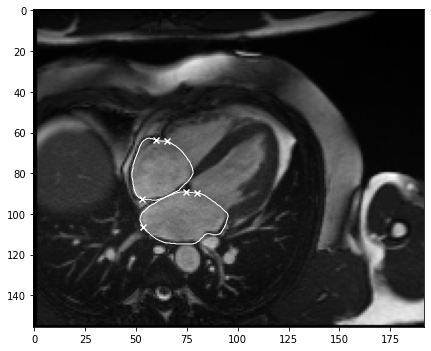

<ipython-input-5-b31f4edd8235>:15: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  lv_ext1, lv_ext2, apex = shapely.affinity.scale(extent, xfact=self.pixel_w, yfact=self.pixel_h)


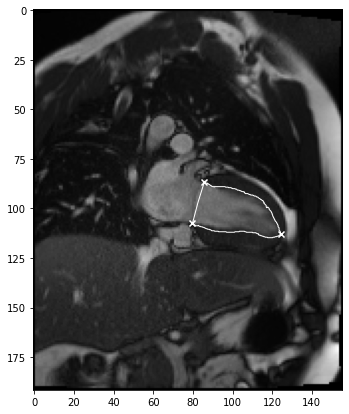

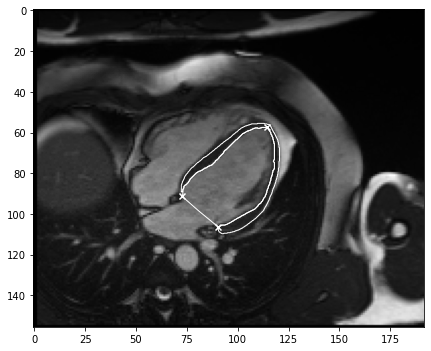

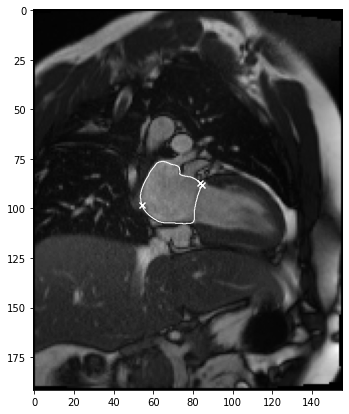

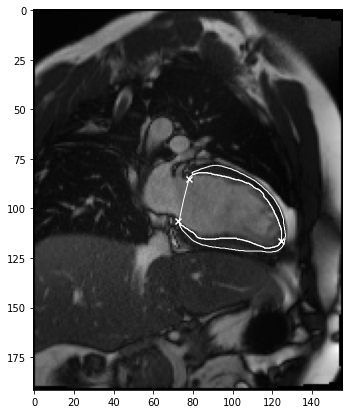

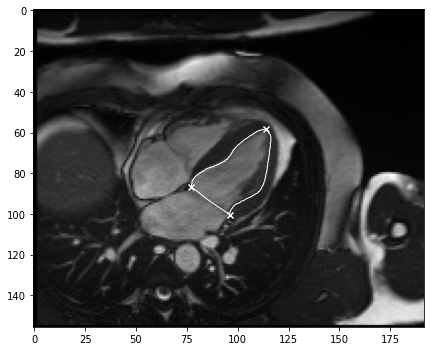

In [5]:
class LAX_CINE_Annotation(Annotation):
    def __init__(self, sop, filepath):
        super().__init__(sop, filepath)

    def set_information(self):
        self.name = 'LAX CINE Annotation'
        self.contour_names = ['lv_lax_endo', 'lv_lax_myo', 'rv_lax_endo', 'ra', 'la']
        self.point_names   = ['lv_lax_extent', 'laxRaExtentPoints', 'laxLaExtentPoints']
        self.pixel_h, self.pixel_w = self.anno['info']['pixelSize'] if 'info' in self.anno.keys() and 'pixelSize' in self.anno['info'].keys() else (-1,-1)#1.98,1.98
        self.h,       self.w       = self.anno['info']['imageSize'] if 'info' in self.anno.keys() and 'imageSize' in self.anno['info'].keys() else (-1,-1)
        
    def length_LV(self):
        if not self.has_point('lv_lax_extent'): return 0
        extent = self.get_point('lv_lax_extent')
        lv_ext1, lv_ext2, apex = shapely.affinity.scale(extent, xfact=self.pixel_w, yfact=self.pixel_h)
        mitral = MultiPoint([lv_ext1, lv_ext2]).centroid
        dist = mitral.distance(apex)
        return dist
        

for sop, annop in case.annos_sop2filepath.items():
    lax_anno = LAX_CINE_Annotation(sop, annop)
    if not ('la' in lax_anno.anno.keys() or 'ra' in lax_anno.anno.keys() or 'lv_lax_endo' in lax_anno.anno.keys()): continue
    img = case.all_imgs_sop2filepath['LAX 4CV'][sop] if sop in case.all_imgs_sop2filepath['LAX 4CV'] else case.all_imgs_sop2filepath['LAX 2CV'][sop]
    img = pydicom.dcmread(img).pixel_array
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    #ax.imshow(np.zeros((200,200)))
    ax.imshow(img, cmap='gray')
    lax_anno.length_LV()
    lax_anno.plot_all_contour_outlines(ax)
    lax_anno.plot_all_points(ax)
    plt.show()

Took:  1.5163650512695312
LAX 4CV LVES 11
LAX 4CV LVED 29
LAX 4CV LA 14
LAX 4CV LA 14
LAX 2CV LVES 11
LAX 2CV LVED 29
LAX 2CV LA 14
4CV LVESV 76.93
4CV LVEDV 158.25
2CV LVESV 66.91
2CV LVEDV 170.00
BIPLANE LVESV 71.80
BIPLANE LVEDV 164.69


<ipython-input-5-b31f4edd8235>:15: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  lv_ext1, lv_ext2, apex = shapely.affinity.scale(extent, xfact=self.pixel_w, yfact=self.pixel_h)


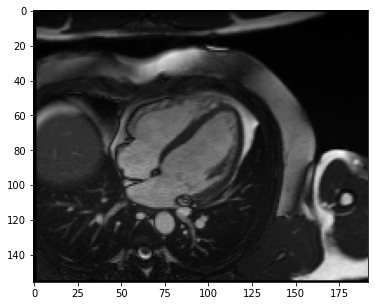

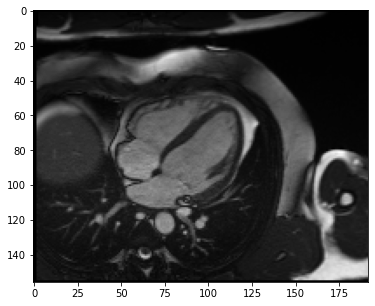

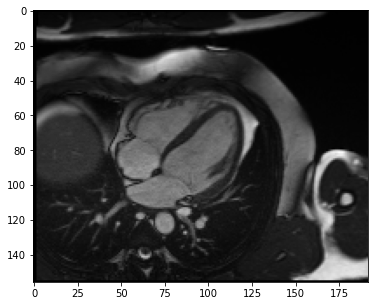

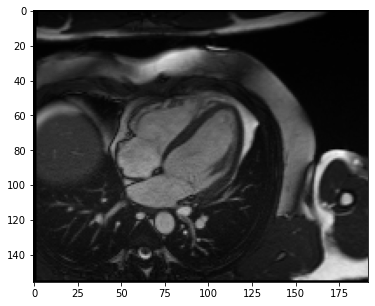

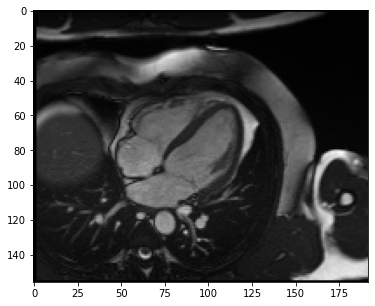

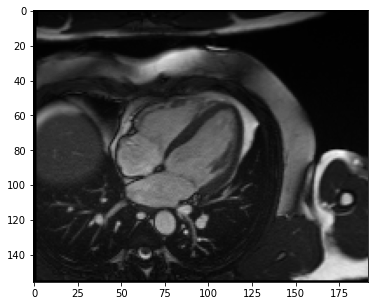

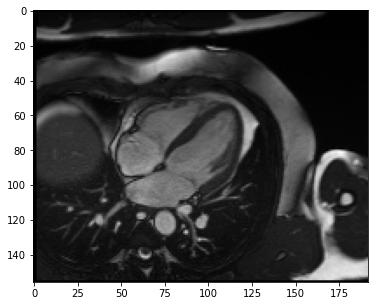

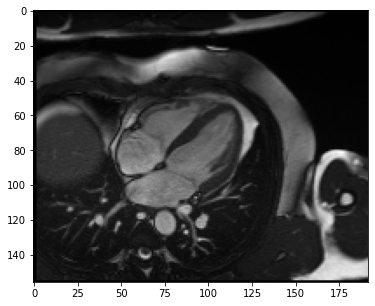

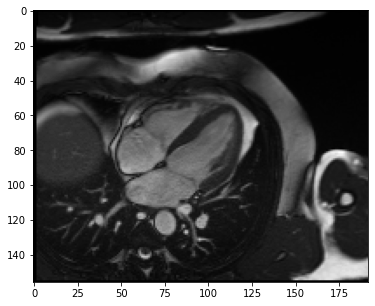

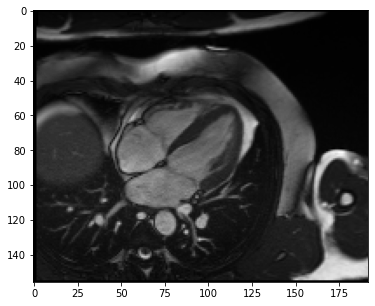

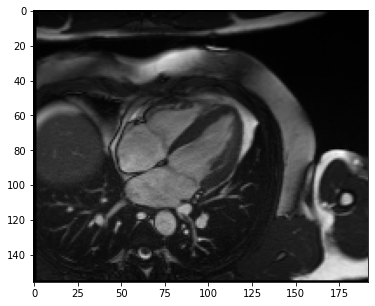

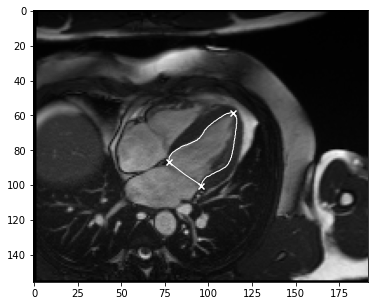

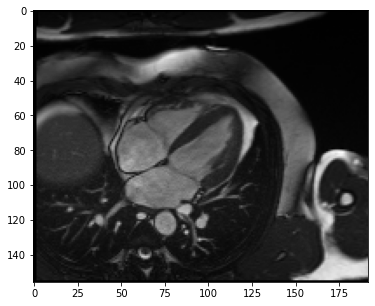

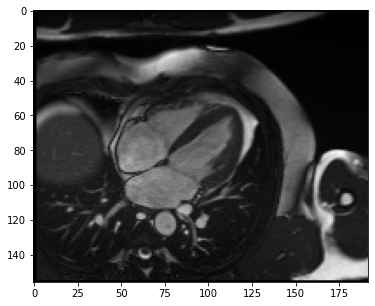

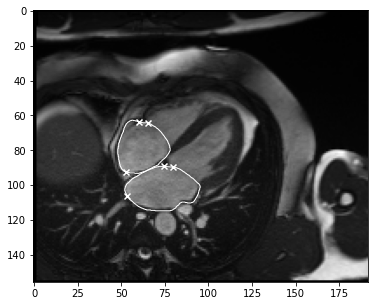

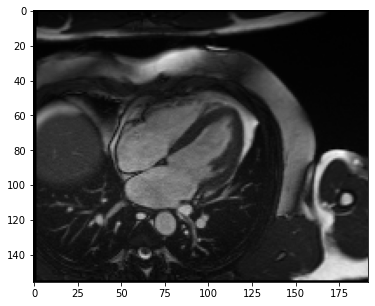

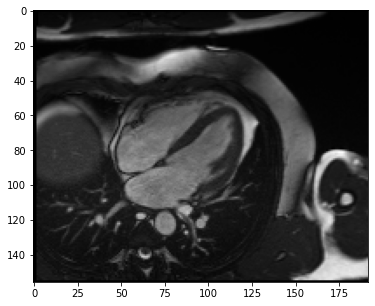

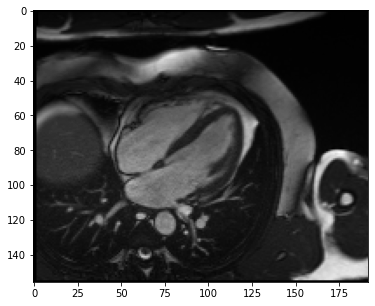

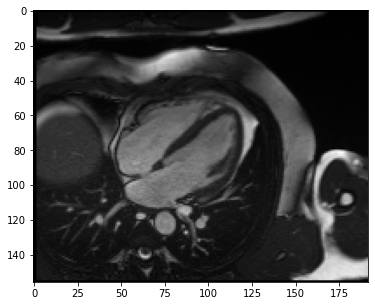

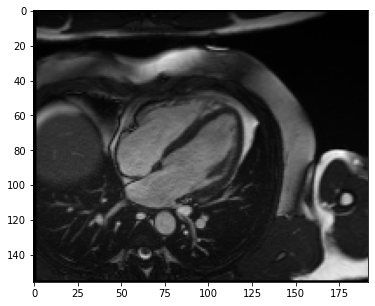

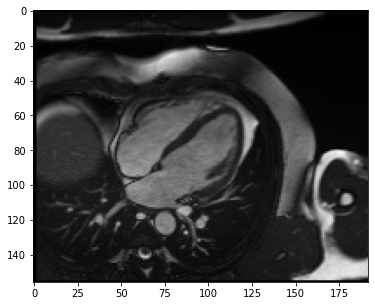

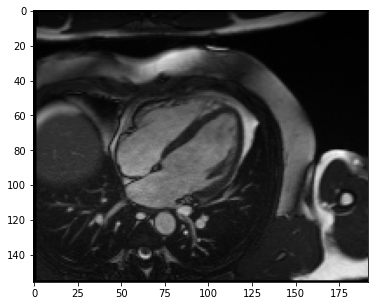

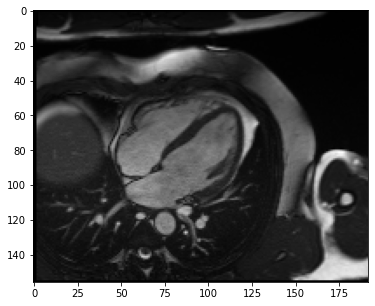

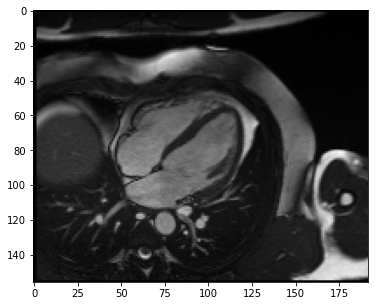

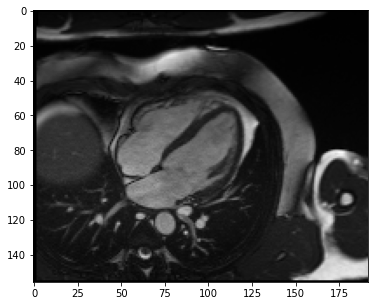

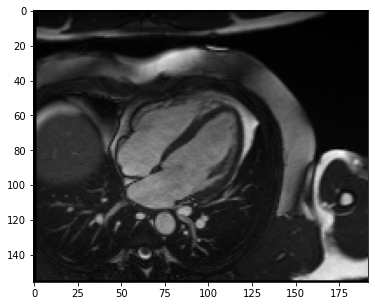

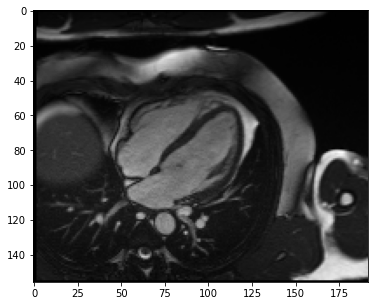

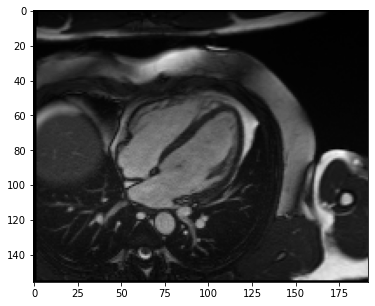

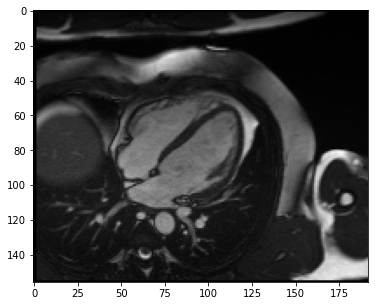

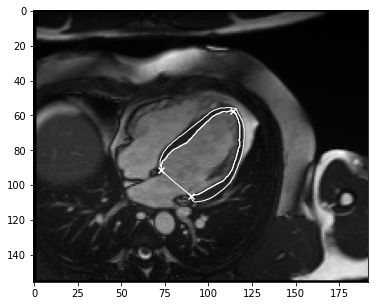

In [13]:
class LAX_CINE_View(View):
    def __init__(self):
        self.colormap            = 'gray'
        self.available_colormaps = ['gray']
        self.load_categories()
        self.contour_names        = ['lv_lax_endo', 'lv_lax_epi', 'lv_lax_myo', 'rv_lax_endo', 'la', 'ra']
        self.contour2categorytype = {c:self.all for c in self.contour_names}
        
        # register tabs here:
        from LazyLuna.Guis.Addable_Tabs.CC_Metrics_Tab                        import CC_Metrics_Tab
        from LazyLuna.Guis.Addable_Tabs.CCs_ClinicalResults_Tab               import CCs_ClinicalResults_Tab
        from LazyLuna.Guis.Addable_Tabs.CCs_Qualitative_Correlationplot_Tab   import CCs_Qualitative_Correlationplot_Tab
        self.case_tabs  = {'Metrics and Figure': CC_Metrics_Tab}
        self.stats_tabs = {'Clinical Results'  : CCs_ClinicalResults_Tab, 
                           'Qualitative Metrics Correlation Plot' : CCs_Qualitative_Correlationplot_Tab}
        
    def load_categories(self):
        self.all = [LAX_4CV_LVES_Category]

    def get_categories(self, case, contour_name=None):
        types = [c for c in self.contour2categorytype[contour_name]]
        cats  = [c for c in case.categories if type(c) in types]
        return cats

    def initialize_case(self, case, debug=False):
        if debug: st=time()
        # switch images
        case.imgs_sop2filepath = {**case.all_imgs_sop2filepath['LAX 2CV'], **case.all_imgs_sop2filepath['LAX 3CV'], **case.all_imgs_sop2filepath['LAX 4CV']}
        # attach annotation type
        case.attach_annotation_type(LAX_CINE_Annotation)
        # if categories have not been attached, attach the first and init other_categories
        # otherwise it has categories and a type, so store the old categories for later use
        if not hasattr(case, 'other_categories'): case.other_categories = dict()
        case.attach_categories([LAX_4CV_LVES_Category, LAX_4CV_LVED_Category,
                                LAX_4CV_LA_Category,   LAX_4CV_LA_Category,
                                LAX_2CV_LVES_Category, LAX_2CV_LVED_Category,
                                LAX_2CV_LA_Category])
        case.other_categories['LAX CINE'] = case.categories
        case.categories = []
        if debug: print('Case categories are: ', case.categories)
        # set new type
        case.type = 'LAX CINE'
        case.available_types.add('LAX CINE')
        if debug: print('Customization in LAX CINE view took: ', time()-st)
        return case
    
    def customize_case(self, case, debug=False):
        if debug: st=time()
        # switch images
        case.imgs_sop2filepath = {**case.all_imgs_sop2filepath['LAX 2CV'], **case.all_imgs_sop2filepath['LAX 3CV'], **case.all_imgs_sop2filepath['LAX 4CV']}
        # attach annotation type
        case.attach_annotation_type(LAX_CINE_Annotation)
        # if categories have not been attached, attach the first and init other_categories
        # otherwise it has categories and a type, so store the old categories for later use
        #print('Has Categories: ', hasattr(case, 'categories'), case.other_categories)
        if not hasattr(case, 'categories'):
            case.other_categories = dict()
            case.attach_categories([LAX_4CV_LVES_Category, LAX_4CV_LVED_Category,
                                    LAX_4CV_LA_Category,   LAX_4CV_LA_Category,
                                    LAX_2CV_LVES_Category, LAX_2CV_LVED_Category,
                                    LAX_2CV_LA_Category])
            case.other_categories['LAX CINE'] = case.categories
        else:
            if 'LAX CINE' in case.other_categories.keys(): case.categories = case.other_categories['LAX CINE']
            else: case.attach_categories([LAX_4CV_LVES_Category, LAX_4CV_LVED_Category,
                                          LAX_4CV_LA_Category,   LAX_4CV_LA_Category,
                                          LAX_2CV_LVES_Category, LAX_2CV_LVED_Category,
                                          LAX_2CV_LA_Category])
        #print('Has Categories: ', hasattr(case, 'categories'), case.categories[0].name, case.categories[0])
        if debug: print('Case categories are: ', case.categories)
        # attach CRs
        case.attach_clinical_results([LAX_4CV_LVESV, LAX_4CV_LVEDV, LAX_2CV_LVESV,
                                      LAX_2CV_LVEDV, LAX_BIPLANE_LVESV, LAX_BIPLANE_LVEDV])
        # set new type
        case.type = 'LAX CINE'
        if debug: print('Customization in LAX CINE view took: ', time()-st)
        return case

    
class LAX_Category:
    def __init__(self, case):
        self.case = case
        self.sop2depthandtime = self.get_sop2depthandtime(case.imgs_sop2filepath)
        self.depthandtime2sop = {v:k for k,v in self.sop2depthandtime.items()}
        self.set_nr_slices_phases()
        self.set_image_height_width_depth()
        self.name = 'none'
        self.phase = None

    def relevant_image(self, dcm):
        return True
        
    def get_sop2depthandtime(self, sop2filepath, debug=False):
        if debug: st = time()
        imgs = {k:pydicom.dcmread(sop2filepath[k]) for k in sop2filepath.keys()}
        imgs = {k:dcm for k,dcm in imgs.items() if self.relevant_images(dcm)}
        sop2depthandtime = {}
        for dcm_sop, dcm in imgs.items():
            phase = int(dcm.InstanceNumber)-1
            sop2depthandtime[dcm_sop] = (0,phase)
        if debug: print('calculating sop2sorting takes: ', time()-st)
        return sop2depthandtime

    def set_image_height_width_depth(self, debug=False):
        if debug: st = time()
        sop = self.depthandtime2sop[(0, 0)]
        dcm = self.case.load_dcm(sop)
        self.height, self.width    = dcm.pixel_array.shape
        self.pixel_h, self.pixel_w = list(map(float, dcm.PixelSpacing))
        try: self.slice_thickness = dcm.SliceThickness
        except Exception as e: print('Exception in LAX_Slice_Phase_Category, ', e)
        if debug: print('Setting stuff took: ', time()-st)

    def set_nr_slices_phases(self):
        dat = list(self.depthandtime2sop.keys())
        self.nr_phases = max(dat, key=itemgetter(1))[1]+1
        self.nr_slices = max(dat, key=itemgetter(0))[0]+1
        
    def get_dcm(self, slice_nr, phase_nr):
        sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        return self.case.load_dcm(sop)

    def get_anno(self, slice_nr, phase_nr):
        sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        return self.case.load_anno(sop)

    def get_img(self, slice_nr, phase_nr, value_normalize=True, window_normalize=True):
        sop = self.depthandtime2sop[(slice_nr, phase_nr)]
        return self.case.get_img(sop, value_normalize=value_normalize, window_normalize=window_normalize)

    def get_area(self, cont_name, phase):
        if np.isnan(phase): return 0.0
        anno = self.get_anno(0, phase)
        pixel_area = self.pixel_h * self.pixel_w
        area = anno.get_contour(cont_name).area*pixel_area if anno is not None else 0.0
        return area

    def get_area_curve(self, cont_name):
        return [self.get_area(cont_name, p) for p in range(self.nr_phases)]


class LAX_4CV_LVES_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 4CV LVES'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 4CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('lv_lax_endo')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return np.nan
        valid_idx = np.where(vol_curve > 0)[0]
        return valid_idx[vol_curve[valid_idx].argmin()]

class LAX_4CV_LVED_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 4CV LVED'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 4CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('lv_lax_endo')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return None
        return np.argmax(vol_curve)

    
class LAX_4CV_LA_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 4CV LA'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 4CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('la')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return None
        return np.argmax(vol_curve)

class LAX_4CV_RA_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 4CV RA'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 4CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('ra')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return None
        return np.argmax(vol_curve)


class LAX_2CV_LVES_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 2CV LVES'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 2CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('lv_lax_endo')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return np.nan
        valid_idx = np.where(vol_curve > 0)[0]
        return valid_idx[vol_curve[valid_idx].argmin()]

class LAX_2CV_LVED_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 2CV LVED'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 2CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('lv_lax_endo')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return None
        return np.argmax(vol_curve)

class LAX_2CV_LA_Category(LAX_Category):
    def __init__(self, case):
        super().__init__(case)
        self.name  = 'LAX 2CV LA'
        self.phase = self.get_phase()
    
    def relevant_images(self, dcm): return 'LAX 2CV' in dcm[0x0b, 0x10].value
    
    def get_phase(self):
        lvendo_vol_curve = self.get_area_curve('la')
        vol_curve = np.array(lvendo_vol_curve)
        has_conts = [a!=0 for a in vol_curve]
        if True not in has_conts: return None
        return np.argmax(vol_curve)

    
class LAX_4CV_LVESV(Clinical_Result):
    def __init__(self, case):
        self.case = case
        self.set_CR_information()

    def set_CR_information(self):
        self.name = '4CV LVESV'
        self.unit = '[ml]'
        self.cat  = [c for c in self.case.categories if isinstance(c, LAX_4CV_LVES_Category)][0]

    def get_cr(self, string=False):
        area = self.cat.get_area('lv_lax_endo', self.cat.phase)
        anno = self.cat.get_anno(0, self.cat.phase)
        cr   = 8/(3*np.pi) * (area**2)/anno.length_LV() / 1000
        return "{:.2f}".format(cr) if string else cr

    def get_cr_diff(self, other, string=False):
        cr_diff = self.get_cr()-other.get_cr()
        return "{:.2f}".format(cr_diff) if string else cr_diff

class LAX_4CV_LVEDV(Clinical_Result):
    def __init__(self, case):
        self.case = case
        self.set_CR_information()

    def set_CR_information(self):
        self.name = '4CV LVEDV'
        self.unit = '[ml]'
        self.cat  = [c for c in self.case.categories if isinstance(c, LAX_4CV_LVED_Category)][0]

    def get_cr(self, string=False):
        area = self.cat.get_area('lv_lax_endo', self.cat.phase)
        anno = self.cat.get_anno(0, self.cat.phase)
        cr   = 8/(3*np.pi) * (area**2)/anno.length_LV() / 1000
        return "{:.2f}".format(cr) if string else cr

    def get_cr_diff(self, other, string=False):
        cr_diff = self.get_cr()-other.get_cr()
        return "{:.2f}".format(cr_diff) if string else cr_diff

class LAX_2CV_LVESV(Clinical_Result):
    def __init__(self, case):
        self.case = case
        self.set_CR_information()

    def set_CR_information(self):
        self.name = '2CV LVESV'
        self.unit = '[ml]'
        self.cat  = [c for c in self.case.categories if isinstance(c, LAX_2CV_LVES_Category)][0]

    def get_cr(self, string=False):
        area = self.cat.get_area('lv_lax_endo', self.cat.phase)
        anno = self.cat.get_anno(0, self.cat.phase)
        cr   = 8/(3*np.pi) * (area**2)/anno.length_LV() / 1000
        return "{:.2f}".format(cr) if string else cr

    def get_cr_diff(self, other, string=False):
        cr_diff = self.get_cr()-other.get_cr()
        return "{:.2f}".format(cr_diff) if string else cr_diff

class LAX_2CV_LVEDV(Clinical_Result):
    def __init__(self, case):
        self.case = case
        self.set_CR_information()

    def set_CR_information(self):
        self.name = '2CV LVEDV'
        self.unit = '[ml]'
        self.cat  = [c for c in self.case.categories if isinstance(c, LAX_2CV_LVED_Category)][0]

    def get_cr(self, string=False):
        area = self.cat.get_area('lv_lax_endo', self.cat.phase)
        anno = self.cat.get_anno(0, self.cat.phase)
        cr   = 8/(3*np.pi) * (area**2)/anno.length_LV() / 1000
        return "{:.2f}".format(cr) if string else cr

    def get_cr_diff(self, other, string=False):
        cr_diff = self.get_cr()-other.get_cr()
        return "{:.2f}".format(cr_diff) if string else cr_diff

class LAX_BIPLANE_LVESV(Clinical_Result):
    def __init__(self, case):
        self.case = case
        self.set_CR_information()

    def set_CR_information(self):
        self.name = 'BIPLANE LVESV'
        self.unit = '[ml]'
        self.cat1 = [c for c in self.case.categories if isinstance(c, LAX_2CV_LVES_Category)][0]
        self.cat2 = [c for c in self.case.categories if isinstance(c, LAX_4CV_LVES_Category)][0]

    def get_cr(self, string=False):
        area1 = self.cat1.get_area('lv_lax_endo', self.cat1.phase)
        area2 = self.cat2.get_area('lv_lax_endo', self.cat2.phase)
        anno1 = self.cat1.get_anno(0, self.cat1.phase)
        anno2 = self.cat2.get_anno(0, self.cat2.phase)
        L     = min(anno1.length_LV(), anno2.length_LV())
        cr    = 8/(3*np.pi) * (area1*area2)/L / 1000
        return "{:.2f}".format(cr) if string else cr

    def get_cr_diff(self, other, string=False):
        cr_diff = self.get_cr()-other.get_cr()
        return "{:.2f}".format(cr_diff) if string else cr_diff
    
class LAX_BIPLANE_LVEDV(Clinical_Result):
    def __init__(self, case):
        self.case = case
        self.set_CR_information()

    def set_CR_information(self):
        self.name = 'BIPLANE LVEDV'
        self.unit = '[ml]'
        self.cat1 = [c for c in self.case.categories if isinstance(c, LAX_2CV_LVED_Category)][0]
        self.cat2 = [c for c in self.case.categories if isinstance(c, LAX_4CV_LVED_Category)][0]

    def get_cr(self, string=False):
        area1 = self.cat1.get_area('lv_lax_endo', self.cat1.phase)
        area2 = self.cat2.get_area('lv_lax_endo', self.cat2.phase)
        anno1 = self.cat1.get_anno(0, self.cat1.phase)
        anno2 = self.cat2.get_anno(0, self.cat2.phase)
        L     = min(anno1.length_LV(), anno2.length_LV())
        cr    = 8/(3*np.pi) * (area1*area2)/L / 1000
        return "{:.2f}".format(cr) if string else cr

    def get_cr_diff(self, other, string=False):
        cr_diff = self.get_cr()-other.get_cr()
        return "{:.2f}".format(cr_diff) if string else cr_diff

    ##########
    ## TODO ##
    ##########
# Now do the Atria and the RV



st = time()
view = LAX_CINE_View()
case = view.initialize_case(case)
case = view.customize_case(case)
print('Took: ', time()-st)

for i in range(7): print(case.categories[i].name, case.categories[i].phase)

for i in range(6): print(case.crs[i].name, case.crs[i].get_cr(string=True))


for p in range(case.categories[4].nr_phases):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    img  = case.categories[0].get_img (0, p)
    anno = case.categories[0].get_anno(0, p)
    ax.imshow(img, cmap='gray')
    anno.plot_all_contour_outlines(ax)
    anno.plot_all_points(ax)
    plt.show()